In [3]:
!pip install matplotlib

     |████████████████████████████████| 7.2MB 385kB/s 
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0c/89/cdd752da48b66f31a0732902cd9800e6d232ce65f6cc4e83f9d9d2bd99aa/kiwisolver-1.3.1-cp38-cp38-macosx_10_9_x86_64.whl
     |████████████████████████████████| 2.8MB 55kB/s 
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install seaborn

  Using cached https://files.pythonhosted.org/packages/68/ad/6c2406ae175f59ec616714e408979b674fe27b9587f79d59a528ddfbcd5b/seaborn-0.11.1-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip install sklearn

  Using cached https://files.pythonhosted.org/packages/1e/7a/dbb3be0ce9bd5c8b7e3d87328e79063f8b263b2b1bfa4774cb1147bfcd3f/sklearn-0.0.tar.gz
     |████████████████████████████████| 7.2MB 61kB/s 
     |████████████████████████████████| 307kB 48kB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=958973cccdfbd88eb4d2f8c17c0002d027353156547a7f09bc4f0d0a66047949
  Stored in directory: /Users/guillaume/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
# https://medium.com/coinmonks/cryptocurrency-price-prediction-using-deep-learning-f738ead48ffd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [74]:
df = pd.read_csv('../data/processed/BTC_finaldb.csv')
df = df.iloc[:,1:]
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime',
       'QuoteAssetVolume', 'NumberofTrade', 'TakerbuybaseV', 'TakerbuyquoteV',
       'date', 'tweet_count', 'daily_sent', 'elonmusk', 'michael_saylor',
       'binance', 'peterlbrandt', 'apompliano', 'cashapp', 'raoulgmi', 'tyler',
       'squawkcnbc', 'scottmelker'],
      dtype='object')

In [70]:
df.dtypes

Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
CloseTime             int64
QuoteAssetVolume    float64
NumberofTrade         int64
TakerbuybaseV       float64
TakerbuyquoteV      float64
date                 object
tweet_count         float64
daily_sent          float64
elonmusk            float64
michael_saylor      float64
binance             float64
peterlbrandt        float64
apompliano          float64
cashapp             float64
raoulgmi            float64
tyler               float64
squawkcnbc          float64
scottmelker         float64
dtype: object

In [18]:
target_col = 'Close'
dataset = df[['Close','Volume']].copy()

def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(dataset, test_size=0.2)

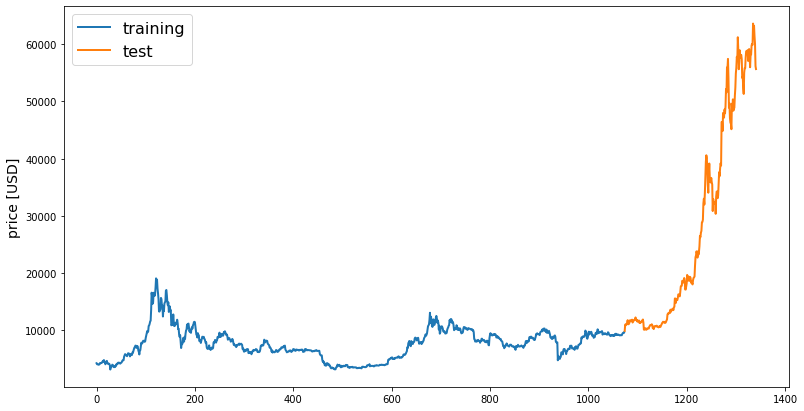

In [19]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [23]:
!pip install tqdm

  Using cached https://files.pythonhosted.org/packages/72/8a/34efae5cf9924328a8f34eeb2fdaae14c011462d9f0e3fcded48e1266d1c/tqdm-4.60.0-py2.py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [29]:
dataset.dtypes

Close     float64
Volume    float64
dtype: object

In [25]:
from tqdm import tqdm
from tensorflow.keras.regularizers import L1L2

# utiliser un scaler => permet de revenir plus facilement en arrière
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in tqdm(range(len(df) - window_len)):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    print("finish extract data")
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    print("finish preparing data")
    return train_data, test_data, X_train, X_test, y_train, y_test

In [43]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    optimizer = optimizers.Adam(
    learning_rate=1e-4)
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 10
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

train, test, X_train, X_test, y_train, y_test = prepare_data(dataset, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

100%|██████████| 263/263 [00:00<00:00, 1063.78it/s]
finish extract data
finish preparing data
Epoch 1/10
34/34 [==============================] - 3s 9ms/step - loss: 0.0119
Epoch 2/10
34/34 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 3/10
34/34 [==============================] - 0s 11ms/step - loss: 0.0094
Epoch 4/10
34/34 [==============================] - 0s 9ms/step - loss: 0.0086
Epoch 5/10
34/34 [==============================] - 0s 9ms/step - loss: 0.0084
Epoch 6/10
34/34 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 7/10
34/34 [==============================] - 0s 9ms/step - loss: 0.0079
Epoch 8/10
34/34 [==============================] - 0s 9ms/step - loss: 0.0076
Epoch 9/10
34/34 [==============================] - 0s 12ms/step - loss: 0.0081
Epoch 10/10
34/34 [==============================] - 0s 9ms/step - loss: 0.0059


In [41]:
history.history['loss'].plot()

AttributeError: 'list' object has no attribute 'plot'

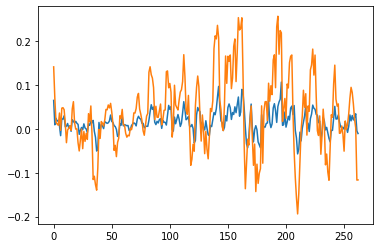

In [46]:
pred = model.predict(X_test) # essayer de revenir en arrière avec la normalisation + créer un pipeline
plt.plot(pred)
plt.plot(y_test)

In [50]:
preds = test[target_col].values[:-window_len] * (pred + 1)
line_plot(test, preds, 'actual', 'prediction', lw=3)
preds = pd.Series(index=test.index, data=preds)

ValueError: Length of passed values is 263, index implies 268.

In [61]:
preds = test[target_col].values[:-window_len] * (preds + 1)
line_plot(targets, preds, 'actual', 'prediction', lw=3)
preds = pd.Series(index=targets.index, data=preds)

ValueError: Length of passed values is 263, index implies 1342.

In [66]:
df.dtypes

Close     float64
Volume    float64
date        int64
dtype: object

In [73]:
df['date'] = pd.to_datetime(df['date'])
df['date']

<ipython-input-73-1527c25da1ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


0      2017-08-17
1      2017-08-18
2      2017-08-19
3      2017-08-20
4      2017-08-21
          ...    
1337   2021-04-15
1338   2021-04-16
1339   2021-04-17
1340   2021-04-18
1341   2021-04-19
Name: date, Length: 1342, dtype: datetime64[ns]

Training
######### ret ########
Epoch 1/5
35/35 [==============================] - 6s 91ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 2/5
35/35 [==============================] - 2s 55ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/5
35/35 [==============================] - 2s 55ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 4/5
35/35 [==============================] - 2s 53ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/5
35/35 [==============================] - 2s 57ms/step - loss: 0.0016 - val_loss: 0.0010
In sample performance
5/5 [==============================] - 0s 14ms/step - loss: 0.0020


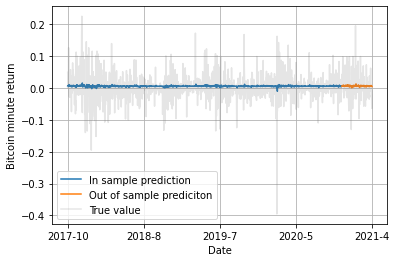

Training
######### price ########
Epoch 1/5
35/35 [==============================] - 9s 128ms/step - loss: 0.0275 - val_loss: 0.0094
Epoch 2/5
35/35 [==============================] - 3s 72ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 3/5
35/35 [==============================] - 3s 85ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 4/5
35/35 [==============================] - 4s 104ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 5/5
35/35 [==============================] - 3s 91ms/step - loss: 0.0030 - val_loss: 0.0092
In sample performance
5/5 [==============================] - 0s 20ms/step - loss: 0.4226


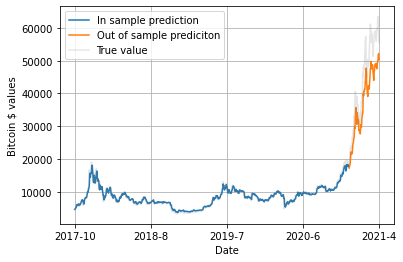

Training
######### abs ########
Epoch 1/5
35/35 [==============================] - 9s 100ms/step - loss: 0.0050 - val_loss: 5.2397e-04
Epoch 2/5
35/35 [==============================] - 2s 62ms/step - loss: 0.0010 - val_loss: 6.0749e-04
Epoch 3/5
35/35 [==============================] - 2s 69ms/step - loss: 0.0012 - val_loss: 5.2084e-04
Epoch 4/5
35/35 [==============================] - 2s 65ms/step - loss: 9.0894e-04 - val_loss: 5.2957e-04
Epoch 5/5
35/35 [==============================] - 2s 71ms/step - loss: 8.5833e-04 - val_loss: 7.3835e-04
In sample performance
5/5 [==============================] - 0s 19ms/step - loss: 0.0014


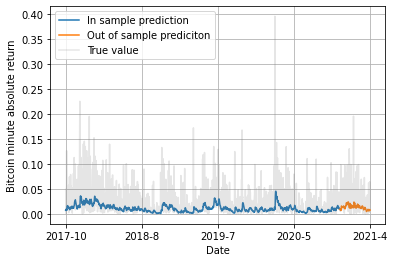

<Figure size 432x288 with 0 Axes>

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)
df = df[['Close','Volume','date']]
df['date'] = pd.to_datetime(df['date'])

for reg in ['ret','price','abs']:
    if reg=='price':
        X = df[['Close']].values
        m = np.mean(X)
        s = np.std(X)
        X=(X-np.mean(X))/np.std(X-np.mean(X))
        y = X
    if reg=='ret':
        X = df[['Close']].values
        X=(X[1:,:]-X[:-1,:])/X[:-1,:]
        y = X
    if reg=='abs':
        X = df[['Close']].values
        X=np.abs((X[1:,:]-X[:-1,:])/X[:-1,:])
        y = X
    batch_size = 1
    time_steps = 50
    k = 0
    x_final = []
    y_final = []
    date = []
    for k in range(X.shape[0]-time_steps-1):
        x_final.append(X[k:k+time_steps,:])
        y_final.append(y[(k + time_steps + 1):(k + time_steps + 2), :])
        date.append(df.loc[k+time_steps+1, 'date'])
    x_final=np.stack(x_final)
    y_final=np.concatenate(y_final)
    
    tr = int(np.ceil(x_final.shape[0]*0.9))
    x_train = x_final[:tr,:,:]
    x_test = x_final[tr:,:,:]
    y_train = y_final[:tr,:]
    y_test = y_final[tr:,:]
    
    # problem => exploding gradient descent
    # set-up the model
    simple_lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(1)
    ])
    
    # compile the model
    opt_adam = tf.keras.optimizers.Adam(lr=0.01, clipnorm=1.)
    opt_adam = tf.keras.optimizers.Adam(lr=0.01, clipvalue=0.5)
    simple_lstm_model.compile(optimizer=opt_adam, loss='mse')
    
    EPOCHS = 5
    print('Training')
    print(f"######### {reg} ########")
    simple_lstm_model.fit(x=x_train,y=y_train, epochs=EPOCHS, validation_split=0.05)
    # in sample performance
    print('In sample performance')
    simple_lstm_model.evaluate(x_test,y_test)
    oos_pred = simple_lstm_model.predict(x_test)
    is_pred = simple_lstm_model.predict(x_train)
    if reg == 'price':
        is_pred=is_pred*s+m
        oos_pred=oos_pred*s+m
        y_final=y_final*s+m
        
    is_x = np.arange(0,tr)
    oos_x = np.arange(tr,x_final.shape[0])
    plt.plot(is_x,is_pred, label='In sample prediction')
    plt.plot(oos_x, oos_pred, label ='Out of sample prediciton')
    plt.plot(np.arange(0,x_final.shape[0]), y_final, label='True value', alpha=0.2, color ='grey')
    if reg == 'price':
        plt.ylabel('Bitcoin $ values')
    if reg == 'ret':
        plt.ylabel('Bitcoin minute return')
    if reg == 'abs':
        plt.ylabel('Bitcoin minute absolute return')

    a = np.ceil(np.linspace(0, len(date)-1,5)).astype(int)
    b = [str(date[x].year)+'-'+str(date[x].month) for x in a]
    plt.xticks(a, b)
    plt.xlabel('Date')
    plt.grid(True)
    plt.legend()

    plt.show()
    #plt.savefig(f'{reg}.png')